In [24]:
import os

import torch
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np

In [64]:
class NextBlock(nn.Module):
    def __init__(self, groups, inc, outc):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=inc, out_channels=outc, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=outc),
            nn.ReLU(),
            nn.Conv2d(in_channels=outc, out_channels=outc, groups=groups, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=outc),
            nn.ReLU()
        )
        self.xtrans = nn.Sequential(
            nn.Conv2d(in_channels=inc, out_channels=outc, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=outc),
            nn.ReLU()
        )
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.layer_stack(x) + self.xtrans(x))
    
class DaNet(nn.Module):
    def __init__(self):
        super().__init__()    
        self.layer_stack = nn.Sequential(
            
            NextBlock(8, 1, 16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            NextBlock(16, 16, 32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            NextBlock(24, 32, 48),
            
            nn.Conv2d(in_channels=48, out_channels=10, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=10),
            nn.ReLU(),
            
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            
            nn.Flatten(),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        return self.layer_stack(x)
        
x = torch.zeros((32, 1, 28, 28))
nb = DaNet()
nb(x).shape

torch.Size([32, 10])

In [65]:
BS = 32
train_dataloader = DataLoader(dataset=FashionMNIST(root="../datasets/", train=True, transform=ToTensor(), download=False),
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=FashionMNIST(root="../datasets/", train=False, transform=ToTensor(), download=False),
                              batch_size=32,
                              shuffle=True)

In [79]:
device = torch.device("mps")
model = DaNet().to(device)

0 2.3056273460388184 0.0625 0.15625
2 2.334496021270752 0.09375 0.09375
4 2.3089492321014404 0.0625 0.0625
6 2.213730573654175 0.28125 0.15625
8 2.2814688682556152 0.15625 0.09375
10 2.302361011505127 0.1875 0.09375
12 2.2607829570770264 0.21875 0.1875
14 2.276632308959961 0.125 0.25
16 2.2479465007781982 0.15625 0.15625
18 2.2323174476623535 0.1875 0.1875
20 2.2805564403533936 0.15625 0.1875
22 2.197157859802246 0.21875 0.1875
24 2.2043590545654297 0.21875 0.25
26 2.2104711532592773 0.28125 0.21875
28 2.2431416511535645 0.125 0.125
30 2.202090263366699 0.1875 0.1875
32 2.188509225845337 0.25 0.125
34 2.165161609649658 0.3125 0.1875
36 2.1546683311462402 0.25 0.15625
38 2.2419424057006836 0.21875 0.28125
40 2.1895220279693604 0.3125 0.21875
42 2.1974987983703613 0.1875 0.1875
44 2.1648998260498047 0.28125 0.09375
46 2.151923894882202 0.3125 0.1875
48 2.1604185104370117 0.3125 0.28125
50 2.1982243061065674 0.21875 0.1875
52 2.1681904792785645 0.28125 0.25
54 2.117377281188965 0.34375 0.

KeyboardInterrupt: 

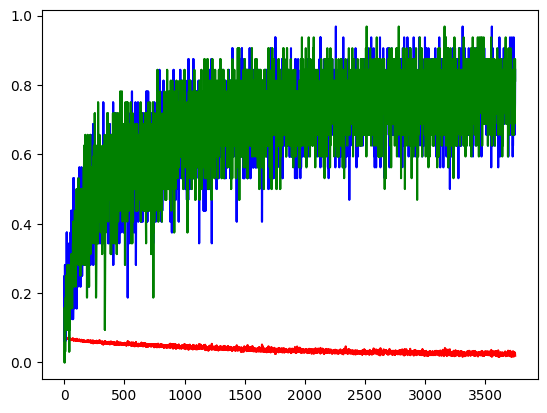

In [80]:
N_EPOCHS = 5
LR = 0.01
MOM = 0.0

losses = []
accs = []
eval_accs = []

crit = nn.NLLLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=LR, momentum=MOM)

for epoch in range(N_EPOCHS):
    
    for batch, (x, y) in enumerate(train_dataloader):
        
        model.train()
        x = x.to(device)
        out = model(x)
        loss = crit(out, y.to(device))
        losses.append(loss.detach().cpu().item()/float(BS))
        acc = (out.detach().cpu().argmax(dim=1)==y).sum().item()/float(BS)
        accs.append(acc)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        model.eval()
        for x_eval, y_eval in test_dataloader:
            eval_pred = model(x_eval.to(device))
            eval_acc = (eval_pred.detach().cpu().argmax(dim=1)==y_eval).sum().item()/float(BS)
            eval_accs.append(eval_acc)
            break
        
        if batch % 2 == 0:
            print(batch, loss.detach().cpu().item(), acc, eval_acc)
            
    plt.plot(losses, c='r')
    plt.plot(accs, c='b')
    plt.plot(eval_accs, c='g')
    plt.savefig("latest_plot.png")
    

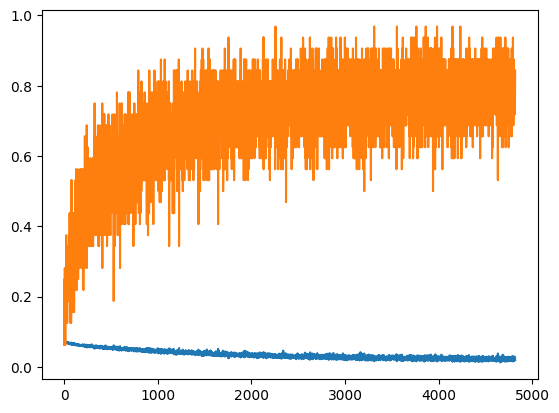

In [82]:
plt.plot(losses)
plt.plot(accs)